# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','DIVERTED','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]
    
def changeTimetoBinary(df, col):
    '''
    change all times in df[col] to binary variable AM (0) or PM (1)
    '''
    mask = df[col] < 12.0
    df.loc[mask, col] = 0
    mask = df[col] >= 12.0
    df.loc[mask, col] = 1
    
def changeDelaytoBinary(df, col):
    '''
    change all delay entries in df[col] to binary vairable no delay attributed (0) and delay attributed
    '''
    mask = df[col] > 0.0
    df.loc[mask, col] = 1

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

# change delay information to binary
changeDelaytoBinary(flights_df, 'CARRIER_DELAY')
changeDelaytoBinary(flights_df, 'WEATHER_DELAY')
changeDelaytoBinary(flights_df, 'NAS_DELAY')
changeDelaytoBinary(flights_df, 'SECURITY_DELAY')
changeDelaytoBinary(flights_df, 'LATE_AIRCRAFT_DELAY')

# for DEP_DELAY, we'd like three variables: -1 (early departure), 0 (regular), 1 (late departure)
mask = flights_df['DEP_DELAY'] > 0.0
flights_df.loc[mask, 'DEP_DELAY'] = 1

mask = flights_df['DEP_DELAY'] < 0.0
flights_df.loc[mask,'DEP_DELAY'] = -1

# TAXI_IN, TAXI_OUT: in 15-minute increments
# 0: less than 15, 1: less than 30, ...
flights_df['TAXI_IN'] = flights_df['TAXI_IN'] // 15
flights_df['TAXI_OUT'] = flights_df['TAXI_OUT'] // 15


Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df in intervals of 10
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures'] // 10
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures'] // 10
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals'] // 10
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals'] // 10
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

In [5]:
# change all times to binary variable AM (0) or PM (1)
changeTimetoBinary(flights_df, 'CRS_DEP_TIME')
changeTimetoBinary(flights_df, 'CRS_ARR_TIME')

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [6]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
# save as CSV
flights_df.to_csv('full_data.csv',index=False)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
DEP_DELAY,1.0,1.0,1.0,1.0,-1.0,0.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,1.0,0.0
TAXI_OUT,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0
TAXI_IN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRS_ARR_TIME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CARRIER_DELAY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [7]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)
# save as CSV
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [8]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [9]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [10]:
arr_15_from = ['CRS_DEP_TIME', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     783.4
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        07:20:26   Log-Likelihood:                 2.8879
No. Observations:                 774   AIC:                             10.22
Df Residuals:                     766   BIC:                             47.44
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0814      0.016      5.181      0.000       0.051       0.112
TAXI_IN                -0.0265      0.016     -1.707      0.088      -0.057       0.004
CRS_ARR_TIME            0.1079      0.013      8.080      0.000       0.082       0.134
CARRIER_DELAY           0.4224      0.021     19.970      0.000       0.381       0.464
NAS_DELAY               0.6509      0.018     35.878      0.000       0.615       0.687
SECURITY_DELAY          0.5257      0.244      2.158      0.031       0.048       1.004
LATE_AIRCRAFT_DELAY     0.3664      0.023     15.859      0.000       0.321       0.412
DelayedDepartureSFO     0.0785      0.034      2.292      0.022       0.011       0.146
==============================================================================
Omnibus:                       36.307   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.178
Skew:                           0.546   Prob(JB):                     1.89e-09
Kurtosis:                       3.235   Cond. No.                         27.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


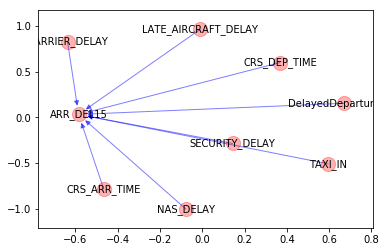

In [11]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [12]:
nas_delay_from =['MONTH', 'TAXI_OUT', 'CARRIER_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     196.0
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          7.30e-116
Time:                        07:20:27   Log-Likelihood:                -439.82
No. Observations:                 774   AIC:                             887.6
Df Residuals:                     770   BIC:                             906.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MONTH                  -0.0096      0.004     -2.636      0.009      -0.017      -0.002
TAXI_OUT                0.2445      0.016     15.082      0.000       0.213       0.276
CARRIER_DELAY           0.2166      0.036      6.043      0.000       0.146       0.287
LATE_AIRCRAFT_DELAY     0.1462      0.039      3.701      0.000       0.069       0.224
==============================================================================
Omnibus:                      201.784   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.616
Skew:                           0.542   Prob(JB):                     4.63e-16
Kurtosis:                       1.993   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


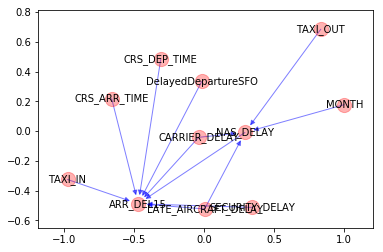

In [14]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [15]:
late_aircraft_from = ['CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME', 'NAS_DELAY', 'SECURITY_DELAY']
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.358
Model:                             OLS   Adj. R-squared:                  0.353
Method:                  Least Squares   F-statistic:                     71.50
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):           9.36e-71
Time:                         07:20:27   Log-Likelihood:                -291.46
No. Observations:                  774   AIC:                             594.9
Df Residuals:                      768   BIC:                             622.8
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CRS_DEP_TIME       0.1836      0.028      6.622      0.000       0.129       0.238
DEP_DELAY          0.1490      0.014     10.760      0.000       0.122       0.176
TAXI_OUT          -0.0476      0.016     -2.912      0.004      -0.080      -0.015
CRS_ARR_TIME       0.1758      0.025      6.894      0.000       0.126       0.226
NAS_DELAY          0.1138      0.029      3.927      0.000       0.057       0.171
SECURITY_DELAY     0.7228      0.355      2.038      0.042       0.027       1.419
==============================================================================
Omnibus:                       82.998   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.762
Skew:                           0.898   Prob(JB):                     6.56e-24
Kurtosis:                       2.708   Cond. No.                         52.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'NAS_DELAY'), ('NAS_DELAY', 'LATE_AIRCRAFT_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [17]:
flight_edges_df, _ = remove_edge('NAS_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'NAS_DELAY', flight_edges_df)


No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [18]:
carrier_delay_from = ['MONTH', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY']
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     83.82
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           2.47e-99
Time:                        07:20:27   Log-Likelihood:                -319.40
No. Observations:                 774   AIC:                             654.8
Df Residuals:                     766   BIC:                             692.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
MONTH              0.0081      0.004      2.192      0.029       0.001       0.015
CRS_DEP_TIME       0.1955      0.033      5.894      0.000       0.130       0.261
DEP_DELAY          0.1986      0.014     13.779      0.000       0.170       0.227
TAXI_OUT          -0.0687      0.018     -3.878      0.000      -0.104      -0.034
CRS_ARR_TIME       0.1691      0.031      5.468      0.000       0.108       0.230
WEATHER_DELAY     -0.5059      0.166     -3.050      0.002      -0.832      -0.180
NAS_DELAY          0.1791      0.030      5.943      0.000       0.120       0.238
SECURITY_DELAY    -0.3554      0.368     -0.965      0.335      -1.078       0.368
==============================================================================
Omnibus:                      133.037   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.721
Skew:                           0.307   Prob(JB):                     1.44e-09
Kurtosis:                       2.058   Cond. No.                         221.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('CARRIER_DELAY', 'NAS_DELAY'), ('NAS_DELAY', 'CARRIER_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [20]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

### WEATHER_DELAY

In [21]:
weather_delay_from = ['LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL']
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.784
Date:                Mon, 09 Apr 2018   Prob (F-statistic):            0.00468
Time:                        07:20:27   Log-Likelihood:                 860.58
No. Observations:                 774   AIC:                            -1713.
Df Residuals:                     770   BIC:                            -1695.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LATE_AIRCRAFT_DELAY       0.0183      0.007      2.708      0.007       0.005       0.032
ScheduledDepartureSFO     0.0023      0.002      1.204      0.229      -0.001       0.006
DelayedArrivalPHL         0.0421      0.020      2.086      0.037       0.002       0.082
ScheduledArrivalPHL      -0.0055      0.004     -1.262      0.207      -0.014       0.003
==============================================================================
Omnibus:                     1379.824   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           698200.150
Skew:                          12.027   Prob(JB):                         0.00
Kurtosis:                     148.159   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

No cycle found! You may proceed.


### CRS Arrival Time

In [23]:
crs_arrival_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO']
regression_model(crs_arrival_from, 'CRS_ARR_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_ARR_TIME   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     369.8
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          4.16e-257
Time:                        07:20:27   Log-Likelihood:                -303.72
No. Observations:                 774   AIC:                             623.4
Df Residuals:                     766   BIC:                             660.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
QUARTER                   0.3935      0.044      8.937      0.000       0.307       0.480
MONTH                    -0.0961      0.015     -6.368      0.000      -0.126      -0.066
DAY_OF_WEEK               0.0555      0.006      9.615      0.000       0.044       0.067
CRS_DEP_TIME             -0.7249      0.026    -27.625      0.000      -0.776      -0.673
TAXI_OUT                  0.1488      0.015     10.027      0.000       0.120       0.178
CARRIER_DELAY             0.1355      0.031      4.390      0.000       0.075       0.196
LATE_AIRCRAFT_DELAY       0.1678      0.034      4.981      0.000       0.102       0.234
ScheduledDepartureSFO     0.0115      0.009      1.315      0.189      -0.006       0.029
==============================================================================
Omnibus:                       18.206   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.598
Skew:                           0.231   Prob(JB):                     2.76e-06
Kurtosis:                       3.762   Cond. No.                         33.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
flight_edges_df, bn = update_flights_edges_df(crs_arrival_from, 'CRS_ARR_TIME', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [25]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [26]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### CRS Departure Time

In [27]:
crs_departure_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'TAXI_OUT', 'CRS_ARR_TIME', 'CARRIER_DELAY','NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO'] 
regression_model(crs_departure_from, 'CRS_DEP_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_DEP_TIME   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     220.6
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          8.41e-206
Time:                        07:20:27   Log-Likelihood:                -282.41
No. Observations:                 774   AIC:                             582.8
Df Residuals:                     765   BIC:                             624.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
QUARTER                   0.2952      0.044      6.741      0.000       0.209       0.381
MONTH                    -0.0654      0.015     -4.389      0.000      -0.095      -0.036
DAY_OF_WEEK               0.0499      0.006      8.798      0.000       0.039       0.061
TAXI_OUT                  0.1492      0.016      9.132      0.000       0.117       0.181
CRS_ARR_TIME             -0.6892      0.025    -27.680      0.000      -0.738      -0.640
CARRIER_DELAY             0.1857      0.030      6.088      0.000       0.126       0.246
NAS_DELAY                -0.0486      0.030     -1.642      0.101      -0.107       0.010
LATE_AIRCRAFT_DELAY       0.1920      0.033      5.824      0.000       0.127       0.257
ScheduledDepartureSFO     0.0146      0.008      1.715      0.087      -0.002       0.031
==============================================================================
Omnibus:                       39.312   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.594
Skew:                           0.465   Prob(JB):                     6.26e-12
Kurtosis:                       3.857   Cond. No.                         34.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(crs_departure_from, 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_DEP_TIME')]


In [29]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME')]


In [30]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [31]:
flight_edges_df, bn = remove_edge('CRS_DEP_TIME', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [32]:
taxi_out_from = ['QUARTER', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     468.7
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          4.45e-272
Time:                        07:20:27   Log-Likelihood:                -855.21
No. Observations:                 774   AIC:                             1724.
Df Residuals:                     767   BIC:                             1757.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.1894      0.021      9.154      0.000       0.149       0.230
CRS_DEP_TIME            0.7174      0.066     10.899      0.000       0.588       0.847
DEP_DELAY              -0.0942      0.034     -2.799      0.005      -0.160      -0.028
CRS_ARR_TIME            0.7190      0.062     11.662      0.000       0.598       0.840
CARRIER_DELAY          -0.2658      0.071     -3.745      0.000      -0.405      -0.126
NAS_DELAY               0.7683      0.055     13.886      0.000       0.660       0.877
LATE_AIRCRAFT_DELAY    -0.2142      0.074     -2.886      0.004      -0.360      -0.068
==============================================================================
Omnibus:                      118.232   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.060
Skew:                           0.836   Prob(JB):                     1.38e-59
Kurtosis:                       5.368   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY'), ('NAS_DELAY', 'CRS_DEP_TIME')]


In [34]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'LATE_AIRCRAFT_DELAY')]


In [35]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY')]


In [36]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [37]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_DEP_TIME')]


In [38]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CRS_DEP_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [39]:
taxi_in_from = ['CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO']
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     8.742
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           1.05e-05
Time:                        07:20:27   Log-Likelihood:                -652.58
No. Observations:                 774   AIC:                             1311.
Df Residuals:                     771   BIC:                             1325.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_ARR_TIME            0.0787      0.028      2.840      0.005       0.024       0.133
LATE_AIRCRAFT_DELAY     0.0888      0.049      1.805      0.071      -0.008       0.185
DelayedDepartureSFO     0.1681      0.079      2.135      0.033       0.014       0.323
==============================================================================
Omnibus:                     1495.626   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2105752.402
Skew:                          13.757   Prob(JB):                         0.00
Kurtosis:                     257.042   Cond. No.                         3.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [41]:
quarter_from = ['MONTH', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME'] 
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.587e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        07:20:27   Log-Likelihood:                -119.79
No. Observations:                 774   AIC:                             249.6
Df Residuals:                     769   BIC:                             272.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3285      0.003    115.926      0.000       0.323       0.334
CRS_DEP_TIME     0.2231      0.026      8.734      0.000       0.173       0.273
DEP_DELAY        0.0288      0.011      2.634      0.009       0.007       0.050
TAXI_OUT         0.0459      0.012      3.717      0.000       0.022       0.070
CRS_ARR_TIME     0.2836      0.024     11.892      0.000       0.237       0.330
==============================================================================
Omnibus:                      449.315   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.487
Skew:                           0.009   Prob(JB):                     2.19e-10
Kurtosis:                       1.826   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [43]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'QUARTER', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [44]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'QUARTER', flight_edges_df)

[('CRS_DEP_TIME', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [45]:
flight_edges_df, bn = remove_edge('CRS_DEP_TIME', 'QUARTER', flight_edges_df)

[('CRS_ARR_TIME', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME')]


In [46]:
flight_edges_df, bn = remove_edge('CRS_ARR_TIME', 'QUARTER', flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [47]:
departure_delay_from = ['QUARTER', 'MONTH', 'CRS_DEP_TIME', 'TAXI_OUT', 'CARRIER_DELAY',  'LATE_AIRCRAFT_DELAY'] 
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     77.94
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           5.25e-76
Time:                        07:20:27   Log-Likelihood:                -900.99
No. Observations:                 774   AIC:                             1814.
Df Residuals:                     768   BIC:                             1842.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.2463      0.091      2.712      0.007       0.068       0.425
MONTH                  -0.1021      0.032     -3.193      0.001      -0.165      -0.039
CRS_DEP_TIME            0.1466      0.056      2.604      0.009       0.036       0.257
TAXI_OUT               -0.1153      0.032     -3.658      0.000      -0.177      -0.053
CARRIER_DELAY           0.8681      0.066     13.095      0.000       0.738       0.998
LATE_AIRCRAFT_DELAY     0.7198      0.073      9.909      0.000       0.577       0.862
==============================================================================
Omnibus:                     2012.779   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.858
Skew:                           0.315   Prob(JB):                     1.12e-15
Kurtosis:                       1.682   Cond. No.                         29.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY')]


In [49]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


In [50]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [51]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'DEP_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [52]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'QUARTER', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [53]:
delayed_SFO_from = ['TAXI_IN', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.252
Model:                             OLS   Adj. R-squared:                  0.249
Method:                  Least Squares   F-statistic:                     86.66
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):           2.52e-48
Time:                         07:20:28   Log-Likelihood:                 44.613
No. Observations:                  774   AIC:                            -83.23
Df Residuals:                      771   BIC:                            -69.27
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TAXI_IN                   0.0278      0.014      1.922      0.055      -0.001       0.056
ScheduledDepartureSFO     0.0670      0.005     12.721      0.000       0.057       0.077
ScheduledArrivalPHL       0.0285      0.008      3.361      0.001       0.012       0.045
==============================================================================
Omnibus:                      371.934   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1708.821
Skew:                           2.260   Prob(JB):                         0.00
Kurtosis:                       8.706   Cond. No.                         3.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

[('TAXI_IN', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'TAXI_IN')]


In [55]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [56]:
delayed_PHL_from = ['DEP_DELAY', 'TAXI_OUT', 'WEATHER_DELAY', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     206.4
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          2.02e-139
Time:                        07:20:28   Log-Likelihood:                 429.28
No. Observations:                 774   AIC:                            -848.6
Df Residuals:                     769   BIC:                            -825.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
DEP_DELAY                -0.0087      0.005     -1.691      0.091      -0.019       0.001
TAXI_OUT                 -0.0185      0.003     -5.321      0.000      -0.025      -0.012
WEATHER_DELAY             0.1525      0.063      2.431      0.015       0.029       0.276
ScheduledDepartureSFO    -0.0099      0.003     -2.911      0.004      -0.017      -0.003
ScheduledArrivalPHL       0.1660      0.005     30.845      0.000       0.155       0.177
==============================================================================
Omnibus:                      230.613   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1717.372
Skew:                           1.135   Prob(JB):                         0.00
Kurtosis:                       9.935   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'WEATHER_DELAY')]


In [58]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Departures from SFO When Delayed Flight is scheduled to Depart

In [59]:
scheduled_SFO_from = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'DelayedDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL']
regression_model(scheduled_SFO_from, 'ScheduledDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ScheduledDepartureSFO   R-squared:                       0.396
Model:                               OLS   Adj. R-squared:                  0.392
Method:                    Least Squares   F-statistic:                     100.8
Date:                   Mon, 09 Apr 2018   Prob (F-statistic):           9.17e-82
Time:                           07:20:28   Log-Likelihood:                -1320.7
No. Observations:                    774   AIC:                             2651.
Df Residuals:                        769   BIC:                             2675.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.5178      0.078      6.616      0.000       0.364       0.671
CRS_ARR_TIME            0.4475      0.066      6.758      0.000       0.318       0.577
DelayedDepartureSFO     2.3104      0.193     11.967      0.000       1.931       2.689
DelayedArrivalPHL      -0.6932      0.343     -2.023      0.043      -1.366      -0.021
ScheduledArrivalPHL     0.3612      0.077      4.706      0.000       0.211       0.512
==============================================================================
Omnibus:                      230.189   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              476.041
Skew:                           1.730   Prob(JB):                    4.26e-104
Kurtosis:                       4.672   Cond. No.                         8.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
flight_edges_df, bn = update_flights_edges_df(scheduled_SFO_from,'ScheduledDepartureSFO',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [61]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

[('CRS_DEP_TIME', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [62]:
flight_edges_df, bn = remove_edge('ScheduledDepartureSFO', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'CRS_DEP_TIME')]


In [63]:
flight_edges_df, bn = remove_edge('ScheduledDepartureSFO', 'CRS_DEP_TIME', flight_edges_df)

[('ScheduledDepartureSFO', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledDepartureSFO')]


In [64]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Arrivals at PHL When Delayed Flight is scheduled to Depart

In [65]:
scheduled_PHL_from = ['DAY_OF_WEEK', 'DEP_DELAY', 'TAXI_OUT', 'WEATHER_DELAY', 'DelayedDepartureSFO', 'ScheduledDepartureSFO', 'DelayedArrivalPHL']
regression_model(scheduled_PHL_from, 'ScheduledArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ScheduledArrivalPHL   R-squared:                       0.667
Model:                             OLS   Adj. R-squared:                  0.664
Method:                  Least Squares   F-statistic:                     219.5
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):          2.24e-178
Time:                         07:20:28   Log-Likelihood:                -717.04
No. Observations:                  774   AIC:                             1448.
Df Residuals:                      767   BIC:                             1481.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
DAY_OF_WEEK               0.0362      0.008      4.394      0.000       0.020       0.052
DEP_DELAY                 0.0333      0.023      1.440      0.150      -0.012       0.079
TAXI_OUT                  0.0720      0.021      3.425      0.001       0.031       0.113
WEATHER_DELAY            -0.5109      0.277     -1.845      0.065      -1.054       0.033
DelayedDepartureSFO       0.3145      0.096      3.277      0.001       0.126       0.503
ScheduledDepartureSFO     0.0766      0.016      4.718      0.000       0.045       0.108
DelayedArrivalPHL         3.2743      0.107     30.687      0.000       3.065       3.484
==============================================================================
Omnibus:                       77.123   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.965
Skew:                           0.534   Prob(JB):                     4.61e-43
Kurtosis:                       5.214   Cond. No.                         58.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
flight_edges_df, bn = update_flights_edges_df(scheduled_PHL_from,'ScheduledArrivalPHL',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'WEATHER_DELAY')]


In [67]:
flight_edges_df, bn = remove_edge('ScheduledArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

[('ScheduledArrivalPHL', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledArrivalPHL')]


In [68]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)

[('DelayedArrivalPHL', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedArrivalPHL')]


In [69]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'ScheduledArrivalPHL', flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [70]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'ScheduledArrivalPHL', flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [71]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'ScheduledArrivalPHL', flight_edges_df)

[('WEATHER_DELAY', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [72]:
flight_edges_df, bn = remove_edge('WEATHER_DELAY', 'ScheduledArrivalPHL', flight_edges_df)

[('ScheduledDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO')]


In [73]:
flight_edges_df, bn = remove_edge('ScheduledDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)
flight_edges_df, bn = remove_edge('ScheduledArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


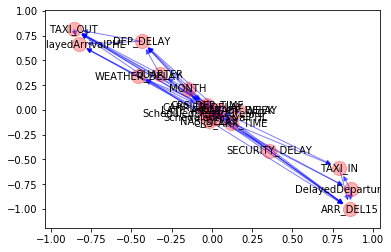

In [74]:
draw_graph(flight_edges_df,'final_bn.png')

In [75]:
print('This graph is a DAG :', nx.is_directed_acyclic_graph(bn),'\nThis edge is a tree :', nx.is_tree(bn))

This graph is a DAG : True 
This edge is a tree : False


In [76]:
# nodes
nodes_li = list(set(list(flight_edges_df['from_node'])+list(flight_edges_df['to_node'])))
nodes_df = pd.DataFrame(nodes_li)
nodes_df.columns = ['nodes']
flight_edges_df.columns=['Source','Target']
# save as csv
flight_edges_df.to_csv('edges.csv',index=False)
nodes_df.to_csv('nodes.csv',index=False)
# numbers to print
print('There are', nodes_df.shape[0], 'nodes and', flight_edges_df.shape[0], 'edges in this graph.')

There are 18 nodes and 53 edges in this graph.
